In [400]:
import time
import requests
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

import matplotlib as mpl
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
mpl.style.use('seaborn-muted')
sns.set(style='whitegrid')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from py2neo import Graph, Node, Relationship

In [381]:
import requests

#   The credentials to be used
login = {
    'username': 'jww@mit.edu',
    'password': 'e38qDkG$tJ'
}

#   Send credentials to login url to retrieve token. Raise
#   an error, if the return code indicates a problem.
#   Please use the URL of the system you'd like to access the API
#   in the example below.
resp_auth = requests.post('https://app.dimensions.ai/api/auth.json', json=login)
resp_auth.raise_for_status()

#   Create http header using the generated token.
headers = {
    'Authorization': "JWT " + resp_auth.json()['token']
}

In [414]:
graph = Graph( "bolt://matlaber5.media.mit.edu:7687", auth=('neo4j','myneo'))
print("Connected to graph database with {:,} nodes and {:,} relationships!".format(
    graph.database.primitive_counts['NumberOfNodeIdsInUse'], 
    graph.database.primitive_counts['NumberOfRelationshipIdsInUse']))

def neo4j_to_df(query, graph):
    print("Starting query...", end=" ")
    query_start_time = time.time()
    df = graph.run(query).to_data_frame()
    print("Done ({:.2f} minutes).".format((time.time()-query_start_time)/60))
    return df
    
top_5 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science']
top_10 = ['Cell', 'Nature', 'Nature Biotechnology','Proceedings of the National Academy of Sciences of the United States of America','Science', 'Journal of the American Chemical Society', 'JAMA', 'The New England Journal of Medicine', 'Nature Genetics', 'Neuron']
top_42 = ['Angewandte Chemie','Blood','Cancer Cell','Cancer Discovery','Cancer Research','Cell','Cell Host & Microbe','Cell Metabolism','Cell Stem Cell','Chemistry & Biology','The EMBO Journal','Genes & Development','Immunity','Journal of Neurology','Journal of the American Chemical Society','JAMA','Journal of Biological Chemistry','Journal of Cell Biology','Journal of Clinical Investigation','Journal of Experimental Medicine','Journal of Medicinal Chemistry','The Lancet','Nature Cell Biology','Nature Chemical Biology','Nature Chemistry','Nature Medicine','Nature Methods','Nature','Nature Biotechnology','The New England Journal of Medicine','Neuron','Nature Genetics','Nature Immunology','Nature Neuroscience','Nature Structural & Molecular Biology','PLOS Biology','PLOS Genetics','PLOS Pathogens','Proceedings of the National Academy of Sciences of the United States of America','Science Signaling','Science Translational Medicine','Science']

Connected to graph database with 278,432,359 nodes and 1,844,501,832 relationships!


In [350]:
# long numbers to human readable string
def human_format(num):
    try:
        num = float('{:.3g}'.format(float(num)))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    except:
        return num

In [415]:
from requests.exceptions import HTTPError
def dimensions_to_df(query):
    try:
        resp = requests.post(
            'https://app.dimensions.ai/api/dsl.json',
            data=query.encode(),
            headers=headers)
        resp.raise_for_status()
    except HTTPError as http_err:
        print('Error while executing query: ', query)
        raise http_err
    ret = resp.json()
    keys = list(ret.keys())
    keys.remove('_stats')
    if len(keys):
        df = pd.DataFrame(ret[keys[0]])
    else:
        df = pd.DataFrame()
    return df, ret['_stats']

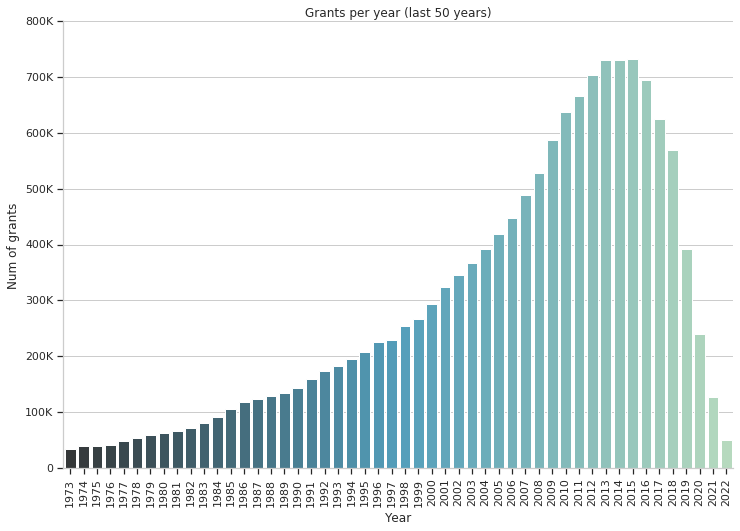

In [368]:
query='search grants return active_year limit 50'
df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "count", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants per year (last 50 years)')
ax.set_ylabel('Num of grants')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

In [37]:
query = ('search grants where resulting_publication_ids is not empty return grants limit 1')
print("Number of grants WITH resulting publications:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search grants where resulting_publication_ids is empty return grants limit 1')
print("Number of grants WITHOUT resulting publications:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where supporting_grant_ids is not empty return publications limit 1')
print("Number of publications WITH a supporting grant:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where supporting_grant_ids is empty return publications limit 1')
print("Number of publications WITHOUT a supporting grant:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funders is not empty return publications limit 1')
print("Number of publications WITH funders:\t\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funders is empty return publications limit 1')
print("Number of publications WITHOUT funders:\t\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

Number of grants WITH resulting publications:		1,160,244
Number of grants WITHOUT resulting publications:	3,420,317
Number of publications WITH a supporting grant:		5,840,914
Number of publications WITHOUT a supporting grant:	95,394,656
Number of publications WITH funders:			10,745,126
Number of publications WITHOUT funders:			90,490,444


Number of funding countries:  61


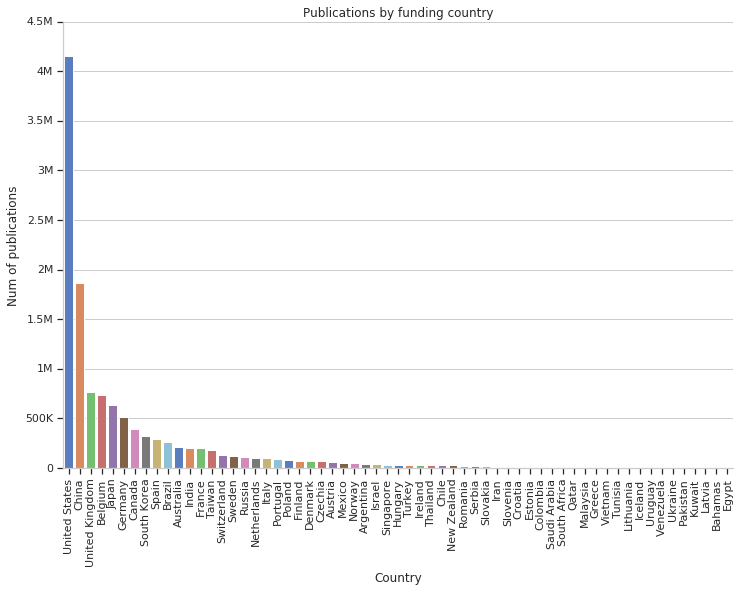

In [367]:
query = ('search publications return funder_countries limit 1000')
df, stats = dimensions_to_df(query)

print("Number of funding countries: ", len(df))

ax = sns.barplot(x = "name", y = "count", data=df, palette="muted")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Publications by funding country')
ax.set_ylabel('Num of publications')
ax.set_xlabel('Country')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

Number of funding countries:  39


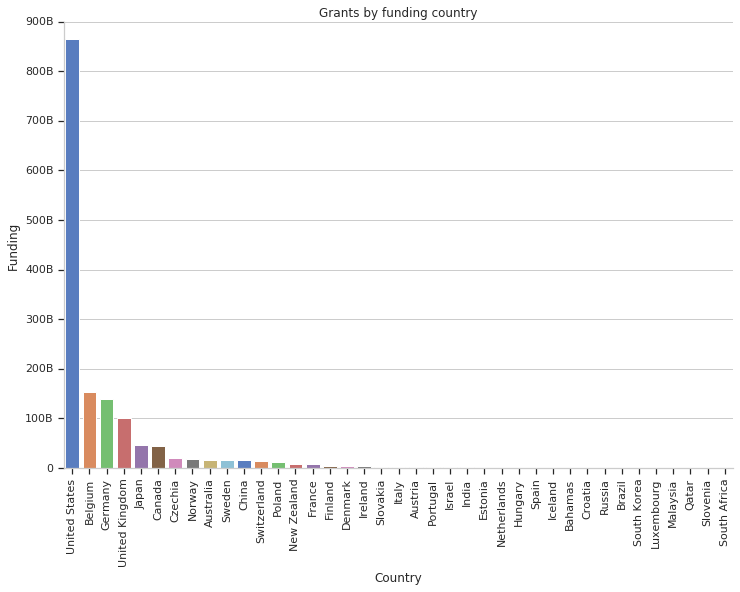

In [366]:
query = ('search grants return funder_countries aggregate funding sort by funding desc limit 1000')
df, stats = dimensions_to_df(query)

print("Number of funding countries: ", len(df))

ax = sns.barplot(x = "name", y = "funding", data=df, palette="muted")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants by funding country')
ax.set_ylabel('Funding')
ax.set_xlabel('Country')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_yticklabels([human_format(tick) for tick in ax.get_yticks().tolist()])
plt.show()

# Maybe the funding number is in different currencies? the China columns seems odd

## From now on, focus on US funded grants/publication

In [46]:
query = ('search grants where funder_countries = "US" and resulting_publication_ids is not empty return grants limit 1')
print("Number of grants WITH resulting publications:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search grants where funder_countries = "US" and resulting_publication_ids is empty return grants limit 1')
print("Number of grants WITHOUT resulting publications:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funder_countries = "US" and supporting_grant_ids is not empty return publications limit 1')
print("Number of publications WITH a supporting grant:\t\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

query = ('search publications where funder_countries = "US" and supporting_grant_ids is empty return publications limit 1')
print("Number of publications WITHOUT a supporting grant:\t{:,}".format(dimensions_to_df(query)[1]['total_count']))

# seems like most of the missing publication -> grant data is non-US

Number of grants WITH resulting publications:		504,799
Number of grants WITHOUT resulting publications:	893,074
Number of publications WITH a supporting grant:		3,277,688
Number of publications WITHOUT a supporting grant:	876,120


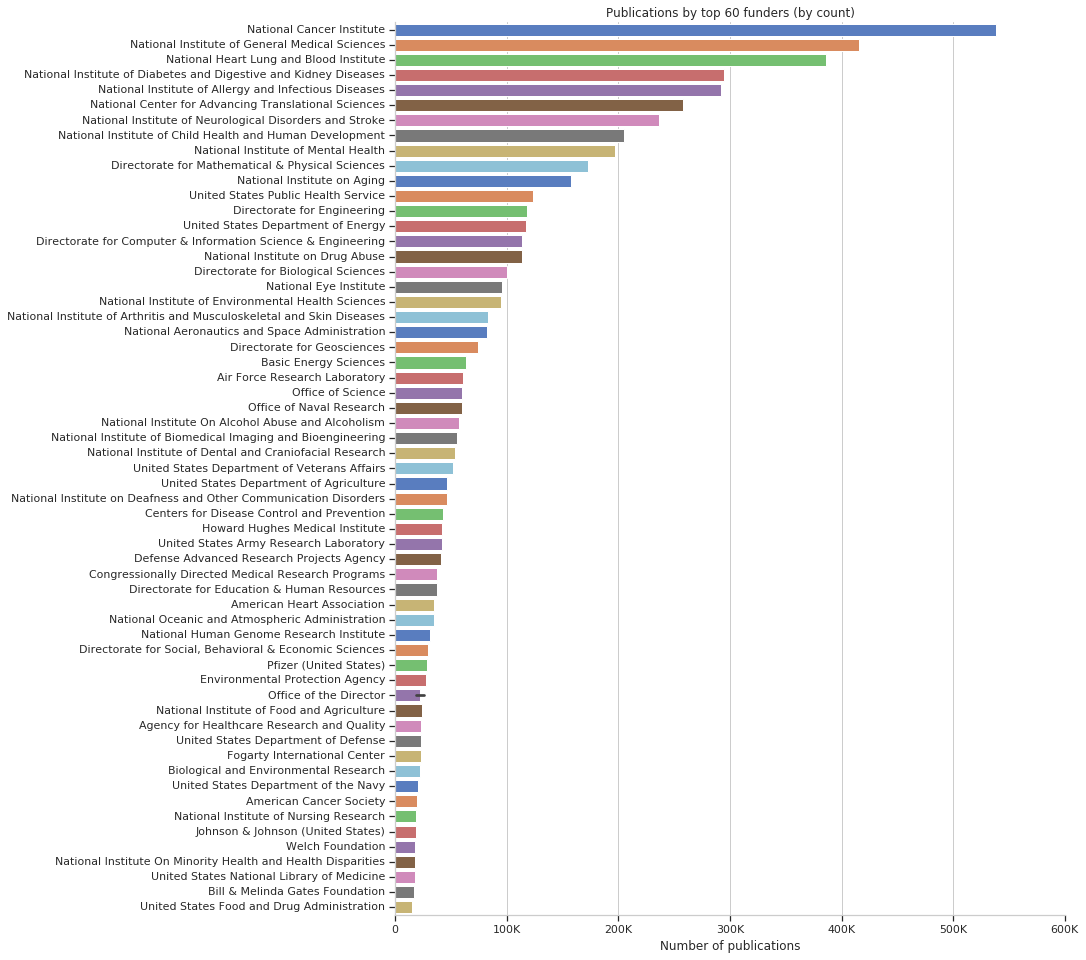

In [365]:
query = ('search publications where funder_countries = "US" return funders limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60)


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "count", data=only_us, orient="h", palette="muted")
ax.set_title('Publications by top 60 funders (by count)')
ax.set_ylabel('')
ax.set_xlabel('Number of publications')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

In [380]:
# check which foundations are in the DB
query = ('search publications where funders.name~"MacArthur" return funders limit 1000')
df, stats = dimensions_to_df(query)
df.head(20)

# no MacArthur Foundation.. :/

""


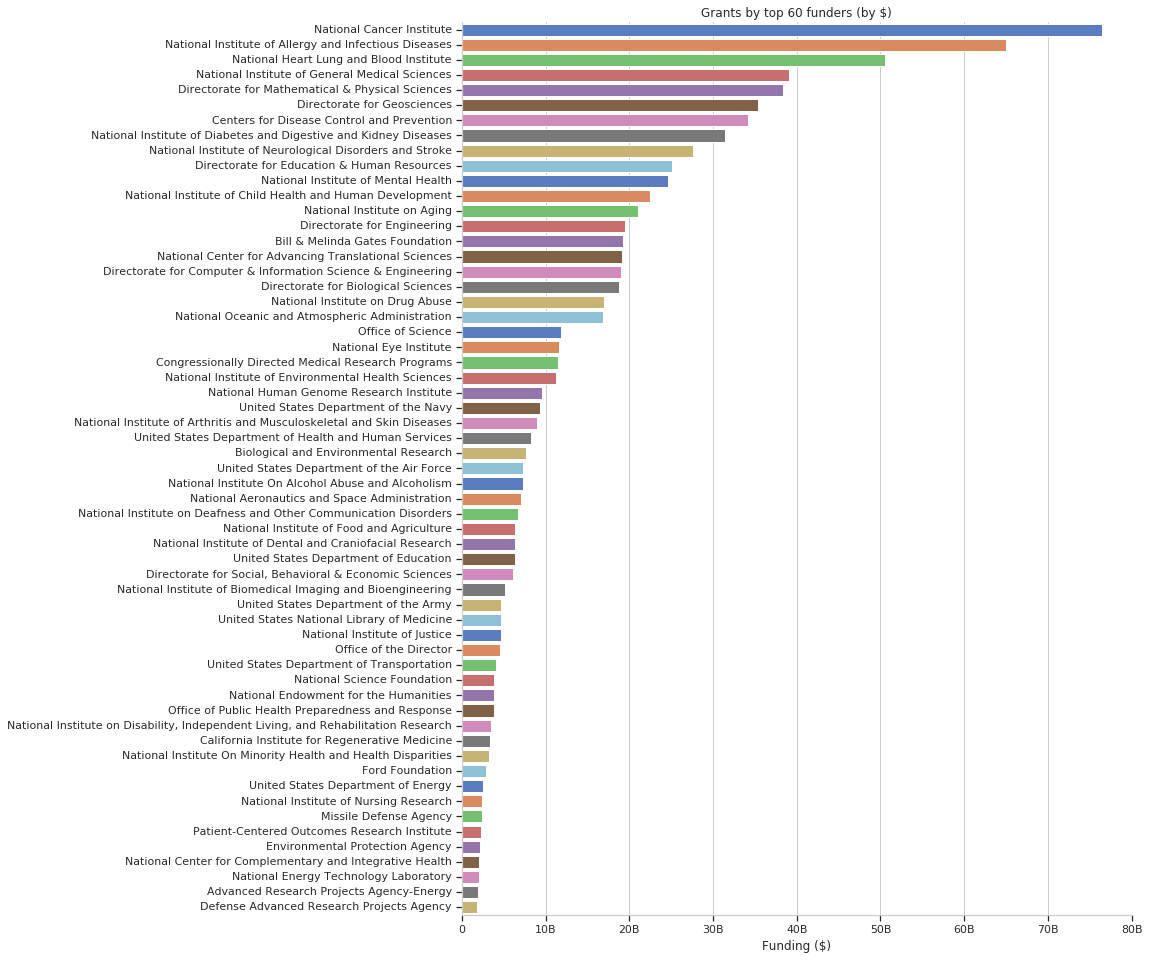

In [364]:
query = ('search grants where funder_countries = "US" return funders aggregate funding  sort by funding desc limit 300')
df, stats = dimensions_to_df(query)
only_us = df[df['country_name'] == 'United States'].head(60)


fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax = ax, y = "name", x = "funding", data=only_us, orient="h", palette="muted")
ax.set_title('Grants by top 60 funders (by $)')
ax.set_ylabel('')
ax.set_xlabel('Funding ($)')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
plt.show()

In [385]:
# fetch all grants per specific funder
#funder = "Defense Advanced Research Projects Agency"
funder = "Bill & Melinda Gates Foundation"

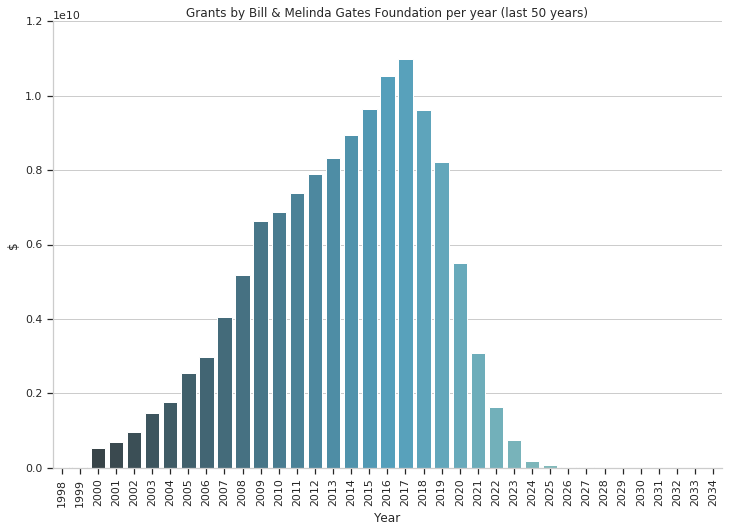

In [386]:
query = (
    'search grants \
    where funders.name = "' + funder + '" \
    and active_year >= 1969 \
    return active_year aggregate funding limit 100'
)

df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "funding", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Grants by ' + funder + ' per year (last 50 years)')
ax.set_ylabel('$')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

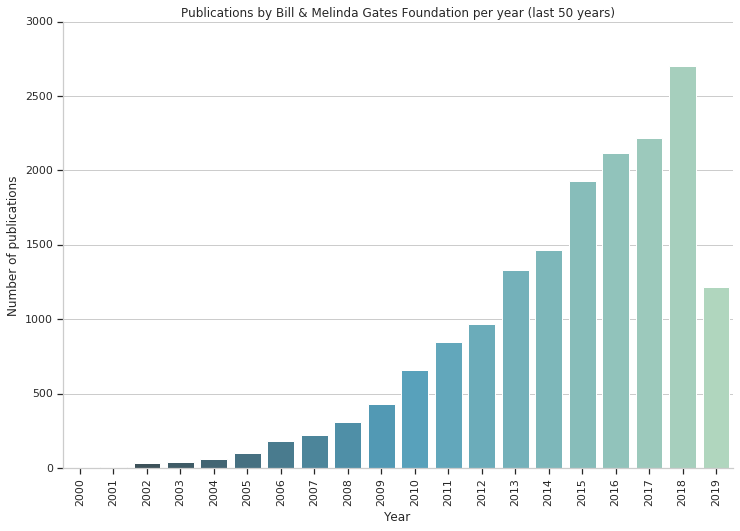

In [387]:
query = (
    'search publications \
    where funders.name = "' + funder + '" \
    and year >= 1969 \
    return year limit 100'
)

df, stats = dimensions_to_df(query)

ax = sns.barplot(x = "id", y = "count", data=df, palette="GnBu_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Publications by ' + funder + ' per year (last 50 years)')
ax.set_ylabel('Number of publications')
ax.set_xlabel('Year')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

In [388]:

print("Fetching grants for", funder)
query = (
    'search grants \
    where funders.name = "' + funder + '" \
    return grants [all - abstract - original_title] \
    sort by id \
    limit 1000 skip '
)

big_df, stats = dimensions_to_df(query + "0")
total = stats['total_count']

if total > 50000:
    raise Exception("Total number of grants for this funder exceeds the maximum fetch-able amount", total)

start = 1
step = 1000
idx = start
for i in range(start * step, total, step):
    time.sleep(2)
    print("%.1f%%" % (float(i) * 100 / total))
    df, stats = dimensions_to_df(query + "%d" % i)
    big_df = pd.concat([big_df, df])
print("Done")

Fetching grants for Bill & Melinda Gates Foundation
14.3%
28.6%
42.9%
57.2%
71.4%
85.7%
Done


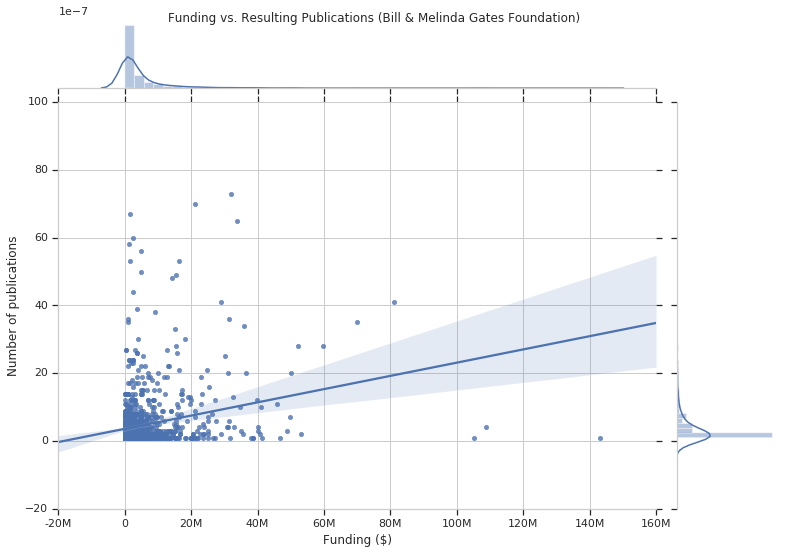

In [389]:
big_df['resulting_publication_len'] = big_df["resulting_publication_ids"].str.len().fillna(0)

g = sns.jointplot(x="funding_usd", y="resulting_publication_len", 
                  data=big_df[big_df['resulting_publication_len'] > 0], kind="reg")
g.fig.suptitle('Funding vs. Resulting Publications (' + funder + ')') 
g.set_axis_labels('Funding ($)', 'Number of publications')
g.ax_marg_y.grid('off')
g.ax_marg_x.grid('off')
g.ax_marg_x.axes.xaxis.tick_bottom()
g.ax_marg_y.axes.yaxis.tick_left()
g.fig.set_figwidth(12)
g.fig.set_figheight(8)
g.ax_joint.set_xticklabels([human_format(tick) for tick in g.ax_joint.get_xticks().tolist()])
plt.show()

In [390]:
many_pubs = 10
grants_with_many_pubs = big_df[big_df['resulting_publication_len'] >= many_pubs]

print("Number of grants with over %d publications: %d" % (many_pubs, len(grants_with_many_pubs)))
i = 0
new_col = []
for index, row in grants_with_many_pubs.iterrows():
    i += 1
    print("%d/%d" % (i, len(grants_with_many_pubs)))
    pubs_ids = ['"%s"' % s for s in row['resulting_publication_ids']]
    query = (
        'search publications \
        where id in [%s] \
        return publications [altmetric + times_cited] \
        limit %d' % (','.join(pubs_ids), len(pubs_ids)))
    try:
        df, stats = dimensions_to_df(query)
    except:
        print("%d was problematic!" % i)
        new_col.append({})
        time.sleep(2)
        continue
    altmetric_sum = 0
    times_cited_sum = 0
    for index2, pub in df.fillna(0).iterrows():
        altmetric_sum += pub.get('altmetric', 0)
        times_cited_sum += pub.get('times_cited', 0)
    new_col.append({
        'altmetric_sum' : altmetric_sum,
        'altmetric_avg' : float(altmetric_sum) / len(df),
        'times_cited_sum' : times_cited_sum,
        'times_cited_avg' : float(times_cited_sum) / len(df)
    })
    time.sleep(2)

Number of grants with over 10 publications: 141
1/141
2/141
3/141
4/141
5/141
6/141
7/141
8/141
9/141
10/141
11/141
12/141
13/141
14/141
15/141
16/141
17/141
18/141
19/141
20/141
21/141
22/141
23/141
24/141
25/141
26/141
27/141
28/141
29/141
30/141
31/141
32/141
33/141
34/141
35/141
36/141
37/141
38/141
39/141
40/141
41/141
42/141
43/141
44/141
45/141
46/141
47/141
48/141
49/141
50/141
51/141
52/141
53/141
54/141
55/141
56/141
57/141
58/141
59/141
60/141
61/141
62/141
63/141
64/141
65/141
66/141
67/141
68/141
69/141
70/141
71/141
72/141
73/141
74/141
75/141
76/141
77/141
78/141
79/141
80/141
81/141
82/141
83/141
84/141
85/141
86/141
87/141
88/141
89/141
90/141
91/141
92/141
93/141
94/141
95/141
96/141
97/141
98/141
99/141
100/141
101/141
102/141
103/141
104/141
105/141
106/141
107/141
108/141
109/141
110/141
111/141
112/141
113/141
114/141
115/141
116/141
117/141
118/141
119/141
120/141
121/141
122/141
123/141
124/141
125/141
126/141
127/141
128/141
129/141
130/141
131/141
132/141
133/

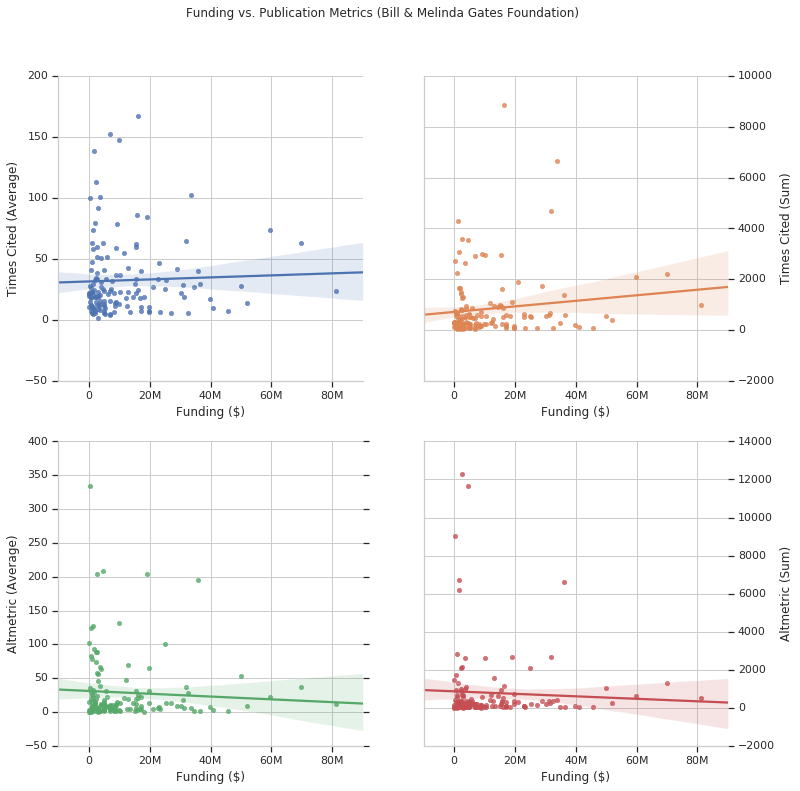

In [391]:
new_df = pd.concat([grants_with_many_pubs.reset_index(), pd.DataFrame(new_col)], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(12,12))
fig.suptitle('Funding vs. Publication Metrics (' + funder + ')') 

sns.regplot(ax = axes[0][0], x="funding_usd", y="times_cited_avg", data=new_df)
axes[0][0].set_ylabel('Times Cited (Average)')
axes[0][0].yaxis.tick_left()
sns.regplot(ax = axes[0][1], x="funding_usd", y="times_cited_sum", data=new_df)
axes[0][1].set_ylabel('Times Cited (Sum)')
axes[0][1].yaxis.set_label_position("right")
axes[0][1].yaxis.tick_right()
sns.regplot(ax = axes[1][0], x="funding_usd", y="altmetric_avg", data=new_df)
axes[1][0].set_ylabel('Altmetric (Average)')
axes[0][0].yaxis.tick_left()
sns.regplot(ax = axes[1][1], x="funding_usd", y="altmetric_sum", data=new_df)
axes[1][1].set_ylabel('Altmetric (Sum)')
axes[1][1].yaxis.set_label_position("right")
axes[1][1].yaxis.tick_right()

for axes2 in axes:
    for ax in axes2:
        ax.set_xticklabels([human_format(tick) for tick in ax.get_xticks().tolist()])
        ax.set_xlabel('Funding ($)')
        ax.xaxis.tick_bottom()


In [ ]:
many_pubs = 10
grants_with_many_pubs = big_df[big_df['resulting_publication_len'] >= many_pubs]

print("Number of grants with over %d publications: %d" % (many_pubs, len(grants_with_many_pubs)))
i = 0
for index, row in grants_with_many_pubs.iterrows():
    i += 1
    print("%d/%d" % (i, len(grants_with_many_pubs)))
    pubs_ids = ['"%s"' % s for s in row['resulting_publication_ids']]
    query = (
        'search publications \
        where id in [%s] \
        return publications [doi + title] \
        limit %d' % (','.join(pubs_ids), len(pubs_ids)))
    try:
        df, stats = dimensions_to_df(query)
        titles = df['title'].tolist()
        
        query_neo4j = """
        MATCH (q:Quanta)
        WHERE q.title in {}
        RETURN 
            q.id
        LIMIT {}
        """.format(titles, len(titles))
        df_neo4j = neo4j_to_df(query_neo4j, graph)
        
        print("Out of %d publications, managed to fetch %d from neo4j (by title)" % (len(df), len(df_neo4j)))
    except:
        print("%d was problematic!" % i)
    time.sleep(2)

Number of grants with over 10 publications: 141
1/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 10 from neo4j (by title)
2/141
Starting query... Done (0.00 minutes).
Out of 38 publications, managed to fetch 24 from neo4j (by title)
3/141
Starting query... Done (0.00 minutes).
Out of 60 publications, managed to fetch 31 from neo4j (by title)
4/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 3 from neo4j (by title)
5/141
Starting query... Done (0.00 minutes).
Out of 41 publications, managed to fetch 24 from neo4j (by title)
6/141
Starting query... Done (0.00 minutes).
Out of 11 publications, managed to fetch 0 from neo4j (by title)
7/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 5 from neo4j (by title)
8/141
Starting query... Done (0.00 minutes).
Out of 14 publications, managed to fetch 6 from neo4j (by title)
9/141
Starting query... Done (0.00 minutes).
Out of 10 publications,

76/141
Starting query... Done (0.00 minutes).
Out of 36 publications, managed to fetch 25 from neo4j (by title)
77/141
Starting query... Done (0.00 minutes).
Out of 20 publications, managed to fetch 16 from neo4j (by title)
